<a href="https://colab.research.google.com/github/mjdall/seeds_on_a_plate/blob/main/seed_contrasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes

It seems rather easy to detect the seeds since your background is homogeneous. You can start by some simple image processing (contrast enhancement, thresholding, contour detection) to detect the seeds and then you can plot red blobs (with the same area as the detected regions) on the original image. As for the shadows, you can check this question
* from this stack overflow [post](https://stackoverflow.com/questions/42918752/how-to-remove-the-shadows-from-these-pictures-using-python-opencv/42933537)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir("/content/drive/MyDrive/seeds_on_a_plate/")

In [3]:
from skimage.color import rgb2gray
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage

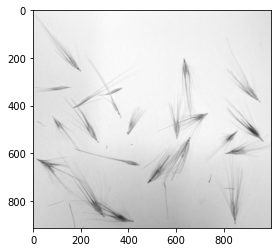

In [4]:
start_image = plt.imread("output/gray/image_4.jpg")

plt.imshow(start_image)

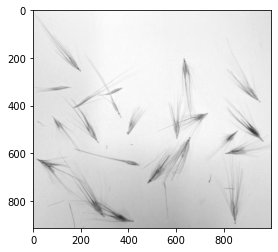

In [5]:
from numba import jit
import numpy as np

image = plt.imread("output/gray/image_4.jpg")

@jit(nopython=True)
def rgb_to_gray(img):
  x_dim = img.shape[1]
  y_dim = img.shape[0]
  return(np.array([[ image[y][x][0] for x in range(x_dim) ] for y in range(y_dim)]))

image = rgb_to_gray(image)
plt.imshow(image, cmap="gray")

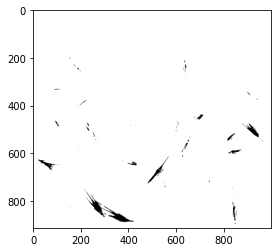

In [8]:
from functools import reduce

def gray_to_perc(img):
  img_copy = np.ndarray(img.shape, np.float64)

  for y in range(img_copy.shape[0]):
    for x in range(img_copy.shape[1]):
      img_copy[y][x] = img[y][x] / 255
  return img_copy

def flatten_img(img, copy=True):
  img2 = img.copy() if copy else img
  img_shape = img2.shape

  if len(img_shape) <= 1:
    return img2
  
  resize_to = reduce(lambda x, y: x*y, img_shape)
  return(img2.reshape(resize_to))

def mask_image(img, threshold):
  original_dims = img.shape
  flat_img = flatten_img(gray_to_perc(img))
  threshold = threshold / 255 if threshold > 1 else threshold

  for i, pixel_val in enumerate(flat_img):
    flat_img[i] = 255 if pixel_val > threshold else 1

  return(flat_img.reshape(original_dims))

plt.imshow(mask_image(image, .55), cmap="gray")

In [9]:
from skimage import exposure

def global_contrast_normalization(img):
  return(exposure.equalize_hist(img))

plt.imshow(global_contrast_normalization(image), cmap="gray")

NameError: ignored

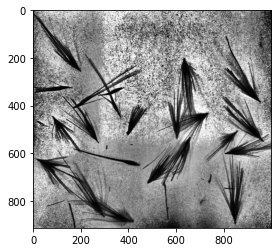

In [10]:
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from skimage.morphology import ball
from skimage.filters import rank

def local_contrast_normalization(img, disk_size=30):
  selem = disk(disk_size)
  return(rank.equalize(img, selem=selem))

plt.imshow(local_contrast_normalization(image, disk_size=100), cmap="gray")

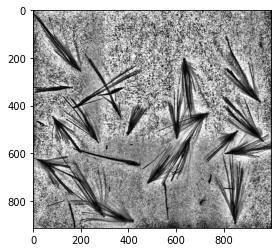

In [11]:
plt.imshow(local_contrast_normalization(image, disk_size=50), cmap="gray")

## Notes
* Local and global contrasting doesn't look amazing for what i'm trying to achieve.
* I'll look at different processing techniques next to try and find a better preprocessing strategy
* I'm trying to separate the shadows + background from the seeds

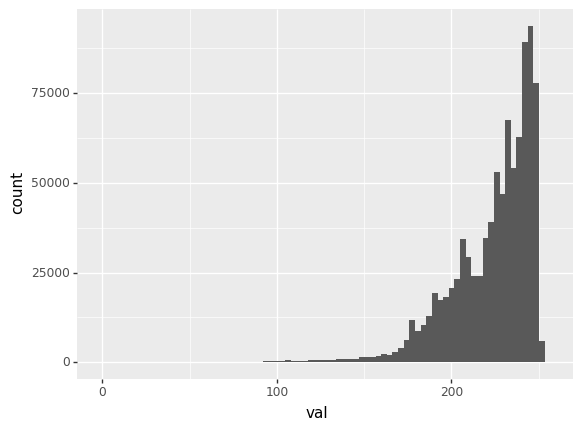

<ggplot: (8731751986813)>

In [12]:
from plotnine import ggplot, aes, geom_histogram, geom_density

def plot_histogram(img):
  pixel_values = pd.DataFrame({ "val": flatten_img(img) })

  return (
      ggplot(pixel_values, aes(x="val")) +
      geom_histogram(bins=80)
  )

plot_histogram(image)

## Gamma Adjustment

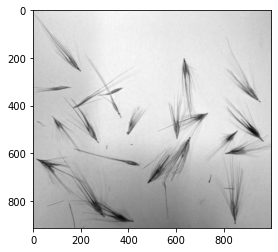

In [13]:
import tensorflow as tf

gamma_adjusted = tf.image.adjust_gamma(image, gamma=2, gain=1).numpy()

plt.imshow(gamma_adjusted, cmap="gray")

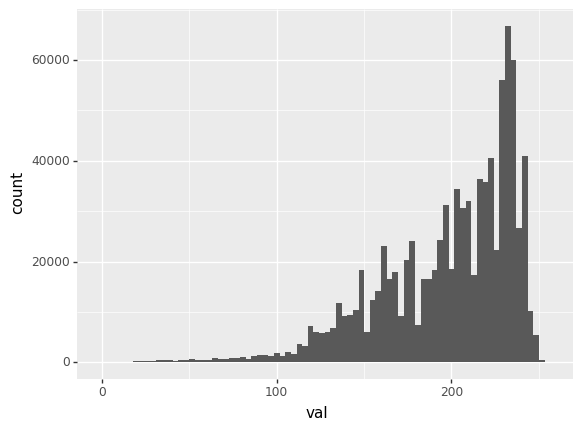

<ggplot: (8731676015973)>

In [14]:
plot_histogram(gamma_adjusted)

## Contrast Adjustment

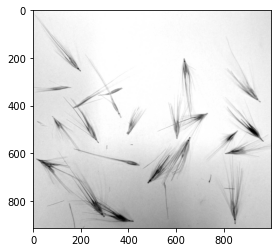

In [15]:
contrast_adjusted = tf.image.adjust_contrast(start_image, 1.5).numpy()

plt.imshow(contrast_adjusted)

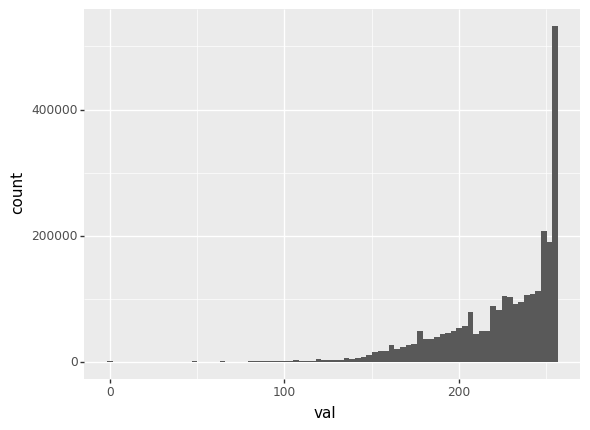

<ggplot: (8731675888713)>

In [16]:
plot_histogram(contrast_adjusted)

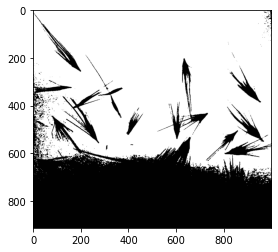

In [37]:
def mask_image(img, threshold=None):
  original_dims = img.shape
  flat_img = flatten_img(img)

  threshold = threshold if threshold is not None else flat_img.mean()

  for i, pixel_val in enumerate(flat_img):
    flat_img[i] = 255 if pixel_val > threshold else 1

  return(flat_img.reshape(original_dims))

contrast_masked = mask_image(contrast_adjusted)

plt.imshow(contrast_masked)

## Contour Detection
* https://learnopencv.com/contour-detection-using-opencv-python-c/#Steps-for-Finding-and-Drawing-Contours-in-OpenCV

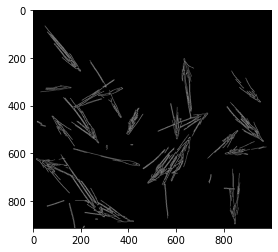

In [19]:
edges = cv2.Canny(contrast_adjusted, 100, 200)

plt.imshow(edges, cmap="gray")

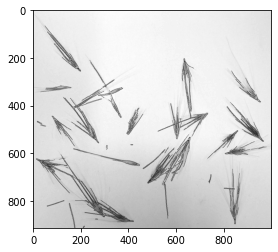

In [20]:
edges_overlay = image.copy()

for y in range(edges.shape[0]):
  for x in range(edges.shape[1]):
    current_value = edges_overlay[y][x]
    if edges[y][x] == 255:
      current_value = 0
    edges_overlay[y][x] = current_value

plt.imshow(edges_overlay, cmap="gray")

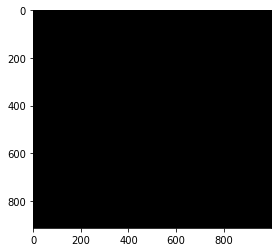

In [24]:
global_norm = global_contrast_normalization(image)

global_norm_edges = cv2.Canny(np.uint8(global_norm), 50, 200)

# todo: get this working
plt.imshow(global_norm_edges, cmap="gray")

In [25]:
import math

@jit(nopython=True)
def gray_to_rgb2(img):
  new_img = []

  for y in range(img.shape[0]):
    row = []
    for x in range(img.shape[1]):
      new_val = math.ceil(img[y][x] * 255)
      new_val = 255 if new_val > 255 else new_val
      new_val = 0 if new_val < 0 else new_val

      row.append([new_val for _ in range(3)])
    new_img.append(row)

  return(img)

new_img = gray_to_rgb2(global_norm)
new_img

array([[0.52331763, 0.56014677, 0.60010843, ..., 0.35398795, 0.35398795,
        0.35398795],
       [0.50623658, 0.54121577, 0.58013034, ..., 0.35398795, 0.35398795,
        0.35398795],
       [0.48971632, 0.52331763, 0.56014677, ..., 0.36644031, 0.35398795,
        0.35398795],
       ...,
       [0.22138116, 0.22138116, 0.22138116, ..., 0.18476342, 0.18476342,
        0.19352793],
       [0.21162212, 0.21162212, 0.21162212, ..., 0.18476342, 0.18476342,
        0.19352793],
       [0.22138116, 0.22138116, 0.22138116, ..., 0.22138116, 0.23115225,
        0.20245345]])

## Removing Shadows from Images

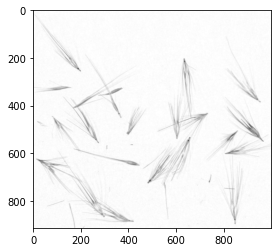

In [48]:
# Shadow removal code:
def remove_shadows(img, norm=True):
  rgb_planes = cv2.split(image)

  result_planes = []

  for plane in rgb_planes:
      dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
      bg_img = cv2.medianBlur(dilated_img, 21)
      diff_img = 255 - cv2.absdiff(plane, bg_img)

      # normalise if set
      if norm:
        diff_img = cv2.normalize(
            diff_img,
            None,
            alpha=0,
            beta=255,
            norm_type=cv2.NORM_MINMAX,
            dtype=cv2.CV_8UC1)

      result_planes.append(diff_img)

  return cv2.merge(result_planes)

no_shadows_norm = remove_shadows(result_norm)
plt.imshow(no_shadows_norm, cmap="gray")

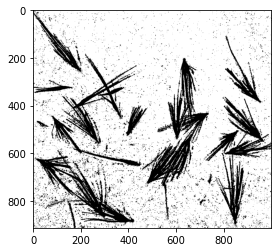

In [49]:
# plotting the mask after shadow removal
plt.imshow(mask_image(no_shadows_norm), cmap="gray")

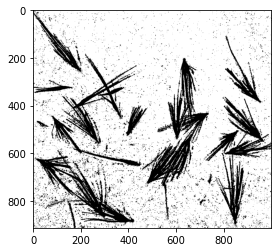

In [50]:
# same outout with or without norm
no_shadows = remove_shadows(result_norm, norm=False)
plt.imshow(mask_image(no_shadows), cmap="gray")

## Finding a good cut point for the mask

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 20947 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


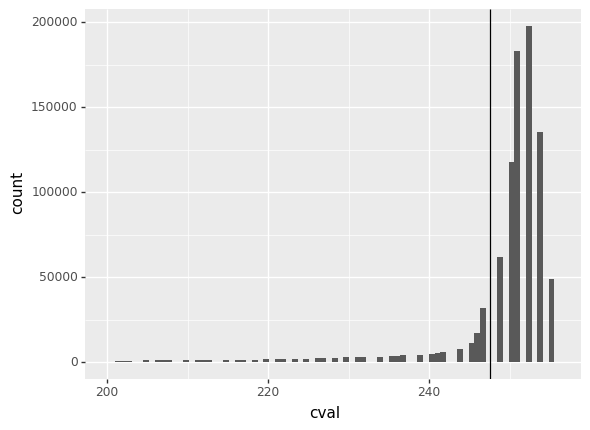

<ggplot: (8731670194233)>

In [47]:
from plotnine import geom_vline, xlim

flat_shadows = flatten_img(no_shadows)
colour_vals = pd.DataFrame({
    "cval": flat_shadows
})

shadow_mean = flat_shadows.mean()

(
    ggplot(colour_vals, aes(x="cval")) +
    geom_histogram(bins=80) +
    geom_vline(xintercept=shadow_mean) +
    xlim(200, 256)
)

In [51]:
shadow_mean

247.51458598028478

In [69]:
flat_shadows.sort()
flat_shadows[len(flat_shadows) // 2]

251

In [96]:
def get_threshold_coverage(img, threshold):
  masked = mask_image(img, threshold=threshold)
  flat_mask = flatten_img(masked)
  perc_img_mask = (flat_mask != 255).sum() / len(flat_mask)
  return(threshold, perc_img_mask)

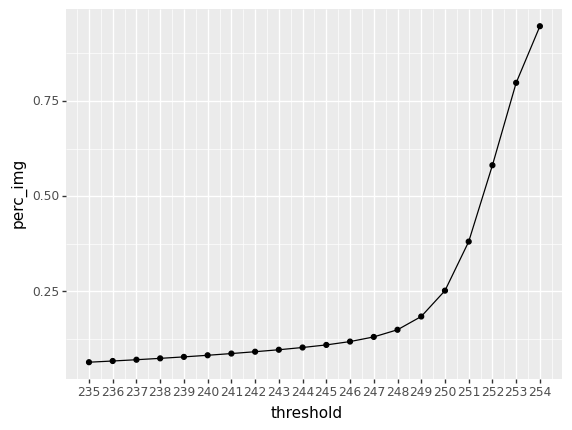

<ggplot: (8731669540849)>

In [99]:
import dask
from plotnine import geom_line, geom_point, scale_x_continuous

dask_list = []
for threshold in range(235, 255):
  dask_list.append(dask.delayed(get_threshold_coverage)(no_shadows, threshold))

results = dask.compute(dask_list)[0]

result_df = pd.DataFrame({
    "threshold": [x[0] for x in results],
    "perc_img": [x[1] for x in results]
})

(
  ggplot(result_df, aes(x="threshold", y="perc_img")) +
  geom_line() +
  geom_point() +
  scale_x_continuous(breaks=range(255))
)

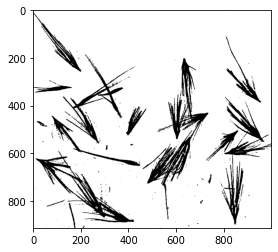

In [105]:
plt.imshow(mask_image(no_shadows, threshold = 245), cmap="gray")

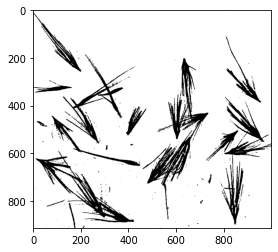

In [107]:
final_mask = mask_image(no_shadows, threshold = 245)
plt.imshow(final_mask, cmap="gray")

## Detecting Seeds on the cleaned mask

In [110]:
final_mask.shape

(913, 1000)

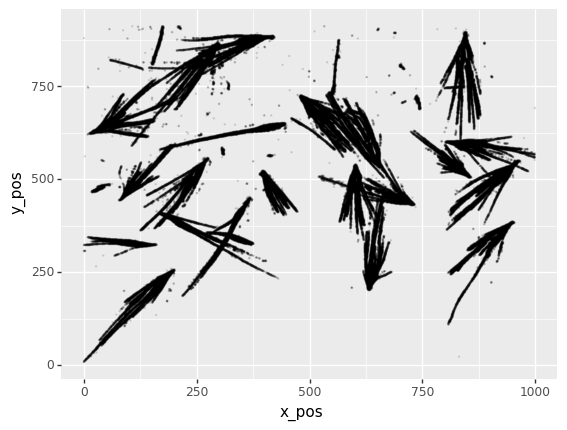

<ggplot: (8731666794741)>

In [115]:
mask_positions = []

for y in range(final_mask.shape[0]):
  for x in range(final_mask.shape[1]):
    pixel_val = final_mask[y][x]
    if pixel_val == 255:
      continue
    mask_positions.append((y, x, pixel_val))

seed_mask = pd.DataFrame({
    "x_pos": [pos[1] for pos in mask_positions],
    "y_pos": [pos[0] for pos in mask_positions],
    "cval": [pos[2] for pos in mask_positions]
})

(
  ggplot(seed_mask, aes(x="x_pos", y="y_pos")) +
  geom_point(size=.01, alpha=.1)
)